# Tailored Recommender Systems With Implicit Feedback

Authors:
- Alexandre Muchinski (s212677)
- Felipe Antonini Miehrig (s212676)
- Filip Sawicki (s202563)

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modules.pipeline import Pipeline

from surprise import Dataset, Reader
from surprise import SlopeOne, KNNWithMeans, KNNBaseline, SVD
from surprise import CoClustering, BaselineOnly, NormalPredictor

from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from collections import defaultdict
import warnings
import re
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [102]:
SAVE_PATH = './data/split'
pipe = Pipeline()

C:\Users\fpsaw\Desktop\42578-Advanced-Business-Analytics\modules\loader.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  df['username'] = df['username'].str.replace(


# Recommender System
## Methodology
### Dataset and Rating
There are two types of possible ratings for recommender systems, those being implicit and explicit. Implicit ratings can binary target variables like 0 and 1, representing the action of buying or not buying a product. On the other hand the explicit are debilerately rated by users such as product reviews. The dataset at hand is originally implicit, because the company doesnt receive a quantitive feedbac by users. However, it was decided to come up with a pseudo-rating, which would represent how much each user $u$ likes item $i$.the following formula was used:
$$
    R(u,i) =\frac{P_i \times Q_{u,i}}{avg(B_u)}
$$
Where $P_i$ is the unit price of item $i$, $Q_{u,i}$ is the quantity of item $i$ purchased by user $u$, and $avg(B_u)$ is the average basket size (price paid for each purchase) for user $u$.

The models used for the recommender system fall into two categories: Colaborative Filtering and Content-based
### Colaborative Filtering
This methods take advantage of the collaborative power of ratings by users to make recommendations. For these models the python package surprise was used. Some models like SVD, Baseline, KNNwithMeans, KNNBaseline and Coclustering were used.

### Content Based
For this kind of approach the caracteristics of each items(features) are used for recommendation. Usually the items descriptions are preprocessed using some form of text analytics and a specific model is fitted for each user. In the case at had, global regression models were fitted using vectorized versions of product descriptions and cetegories alongside user specific features:
* User Features
    - is_b2c: Binary feature that indicates if user is B2C or not
    - is_it: Binary feature that indicates if user id equals payer id
    - latitude: the north–south position of user
    - longitude: the east-west position of user
    - population: the number of inhabitants in the city where user is located
* Item Features
    - Bag of Words: Vector representation of occurances of terms in item description concatenated with item categories with n-grams from 1 to 2
    
For the content based models standard regressor models were fit, like Lasso, MLPRegressor and RandomForestRegressor.

### Model Assesment
When it comes to recommendation systems, assessing the models performance is not as straight forward as when assessing a standard regression model. There might be some trade-offs between some metrics and ideally, the model assesment would be conducted in an online basis with customer surveys and AB testing. With Historical data, as the one at hand, there are some metrics that are commonly used like:
* Mean Absolute Error
$$
    MAE = \frac{\sum^u \sum^i |e_{u,i}|}{N}
$$
    
* Root Mean Squared Error
$$
    RMSE = \frac{\sum^u \sum^i e_{u,i}^2}{N}
$$
* Precision at $k$
$$
    Precision(k) = \frac{|S(k) \cap G|}{|S(k)|}
$$
* Recall at $k$
$$
    Recall(k) = \frac{|S(k) \cap G|}{|G|}
$$
* F1-score at $k$
$$
    F1(k) = \frac{2 \times Precision(k) \times Recall(k)}{Precision(k) + Recall(k)}
$$

Where $S(k)$ is the set of top $k$ items scored by the algorithm and $G$ represents the true set of relevant items (ground-truth positives)

Models were tested on three datasets constructed by applying global temporal split (with a rolling window of 3 months) on all transactions data. The implementation details can be found in RecPipe notebook.

### Hybrid Model
After estimating all the individual models (Collaborative Filtering and Content Based), those were combined into a hybrid model using a simple Linear Regression in order to find the optimal linear combination of the output of each model. That being the case, weights are assigned to each model and the more accurate ones are expected to have higher coefficients. 
### Conclusion / Results
It could be seen that all individual models performed considerably well when compared to the normal predictor. The Baseline predictor and the SVD with 300 components had good results in MAE while some content based like Lasso and Random Forest performed better on the f1-scores. 

However, the Hybrid model showed superior scores on on error metrics and also on F1-scores. The resulting distributions seemed to resemble more the true values. In contrast with a standard regression task, looking only at error metrics is not enough. The end goal is to have usefull predictions for the users, thus the ordering of predicted ratings of products for each user is arguibly more important then "raw accuracy". All in all, the ensemble(hybrid) recommender system should provide a more accurate and robust option in comparison to the individual models.

In [17]:
pipe.df_cust['is_b2c'] = pipe.df_cust['is_b2c'].apply(lambda x: int(x))
pipe.df_cust['is_it'] = pipe.df_cust['id'] == pipe.df_cust['payer_id']
pipe.df_cust['is_it'] = pipe.df_cust['is_it'].apply(lambda x: int(x))

In [18]:
cust_features = ['id', 'is_b2c', 'is_it', 'latitude', 'longitude', 'population']

In [14]:
def prepare_item_features(pipe):
    desc_df = pipe.df_prod
    desc_df['brand'] = desc_df['brand'].apply(lambda x: str(x))
    desc_df['category'] = desc_df['category'].apply(lambda x: str(x))
    desc_df['description'] = desc_df['descr'] + ' ' + desc_df['brand'] + ' ' + desc_df['category']
    desc_df['description'] = desc_df.description.apply(lambda x: np.nan if x == '' else re.sub('\W',' ',x.lower()))
    vectorizer = CountVectorizer(ngram_range = (1, 2), max_df = 0.95, min_df = 0.001)
    X = vectorizer.fit_transform(desc_df.description.values)
    
    names = vectorizer.get_feature_names()
    df = pd.DataFrame.sparse.from_spmatrix(X)
    df.columns = names
    df.index = desc_df.sku.values
    return df

In [19]:
df_prod = prepare_item_features(pipe)

c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
def load_dataset(i, pipe, df_prod):
    train = pd.read_pickle(f'{SAVE_PATH}/train_{i}.pkl')[['cust_id', 'sku', 'rank']]
    test = pd.read_pickle(f'{SAVE_PATH}/test_{i}.pkl')[['cust_id', 'sku', 'rank']]
    train = train.merge(
        pipe.df_cust[cust_features], how='inner', left_on='cust_id', right_on='id').dropna()
    test = test.merge(
        pipe.df_cust[cust_features], how='inner', left_on='cust_id', right_on='id').dropna()
    train = train.merge(
        df_prod, how='inner', left_on='sku', right_index=True)
    test = test.merge(
        df_prod, how='inner', left_on='sku', right_index=True)
    return train, test

## Testing Individual Models

Notes:


In [28]:
train, test = load_dataset(0, pipe, df_prod)
reader = Reader(rating_scale=(0, 100))

In [29]:
# train and test algorithm.
def predict(algo, test):
    predictions = []
    for idx, row in test.iterrows():
        pred = algo.predict(str(row.cust_id), str(row.sku), r_ui=row['rank'])
        predictions.append(pred)
    return predictions

In [30]:
def precision_recall(test, preds, k):
    users = test.cust_id.values
    items = test.sku.values
    rankings = test['rank'].values
    user_dict = {}
    for user in users:
        user_dict[user] = {}
    for i, user in enumerate(users):
        user_dict[user][items[i]] = {'real': rankings[i], 'est': preds[i]} 
    scores = {}
    for user in user_dict.keys():
        if len(user_dict[user])>k:
            transposed = pd.DataFrame(user_dict[user]).transpose()
            total_items = len(transposed['real'].sort_values(ascending = False).index.values)
            real_list = transposed['real'].sort_values(ascending = False).index.values[:k]
            est_list = transposed['est'].sort_values(ascending = False).index.values[:k]
            intersect = np.intersect1d(real_list, est_list)
            precision_k = len(intersect)/k
            recall_k = len(intersect)/total_items
            if (precision_k*recall_k) != 0:
                f1_k = 2*precision_k*recall_k/(precision_k+recall_k)
            else:
                f1_k = 0
            scores[user] = {'precision': precision_k, 
                           'recall': recall_k,
                           'f1_score':f1_k}
            df = pd.DataFrame(scores).transpose()
            df.mean()
    return df.mean(), scores, user_dict

In [42]:
def show_metrics(preds, title, is_surprise, show_plot=True):
    if is_surprise:
        y_true = np.array([p.r_ui for p in preds])
        y_pred = np.array([p.est for p in preds])
    else:
        y_true = preds[0]
        y_pred = preds[1]
    res, _, _ = precision_recall(test, y_pred, k=10)
    prec = res['precision']
    recl = res['recall']
    f1 = res['f1_score']
    
    if show_plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,6))
        ax.set_title(f'Distribution of {title}')
        ax.hist(y_true, bins=100, label=f'true')
        ax.hist(y_pred, bins=100, label=f'pred')
        ax.legend(prop={'size': 12})
    return {
        'Model': title,
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RSME': mean_squared_error(y_true, y_pred) ** (1/2),
        'Precision@10': round(prec, 3),
        'Recall@10': round(recl, 3),
        'F1@10': round(f1, 3)
    }

Running: NormalPredictor
Running: BaseLine
Estimating biases using als...
Running: KNNWithMeans k=20
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: KNNBaseline k=10
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: CoClustering20x20
Running: SVD5
Running: SVD300
Running: Lasso


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Running: RandomForest100


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,Model,R2,MAE,RSME,Precision@10,Recall@10,F1@10
0,NormalPredictor,-1.296219,16.853122,22.168235,0.607,0.414,0.483
1,BaseLine,0.331270,8.397340,11.963273,0.813,0.518,0.617
2,KNNWithMeans k=20,0.057070,9.477477,14.205747,0.761,0.484,0.577
3,KNNBaseline k=10,0.181229,8.565956,13.237490,0.790,0.505,0.601
4,CoClustering20x20,-0.297898,10.099990,16.666510,0.752,0.488,0.579
5,SVD5,-0.153361,9.712022,15.711120,0.762,0.494,0.586
6,SVD300,0.260925,8.284428,12.576762,0.774,0.503,0.596
7,Lasso,0.321975,9.186287,12.046126,0.810,0.514,0.612
8,RandomForest100,0.169702,8.452208,13.330344,0.798,0.508,0.605


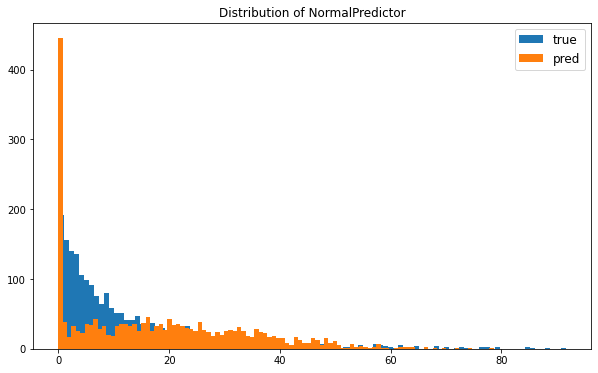

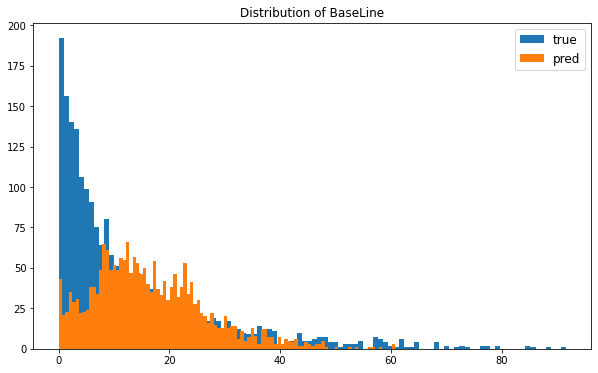

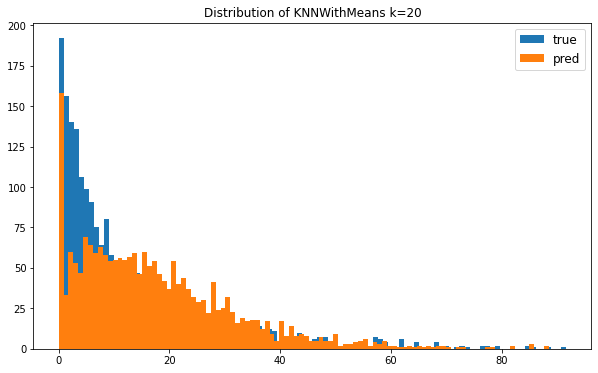

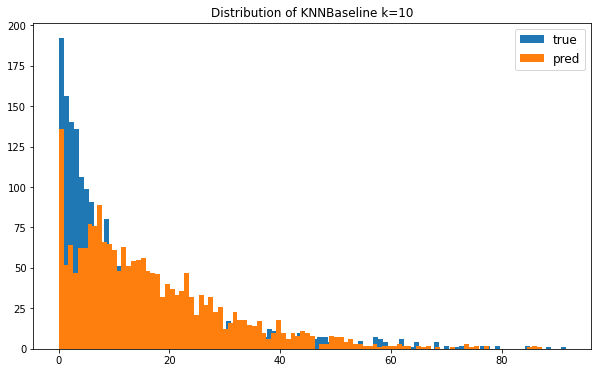

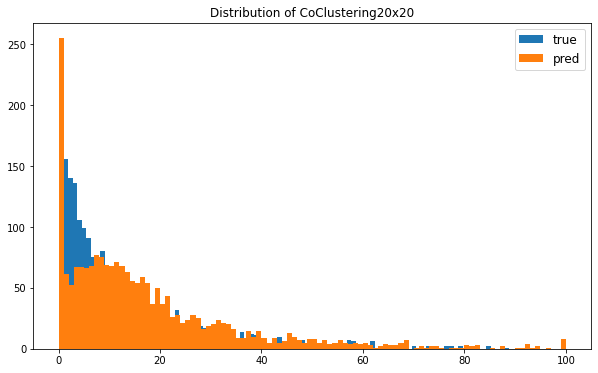

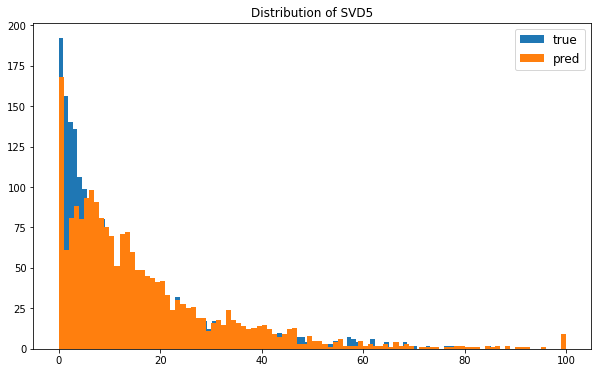

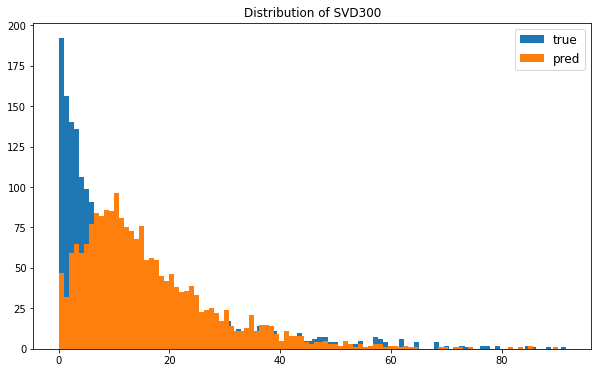

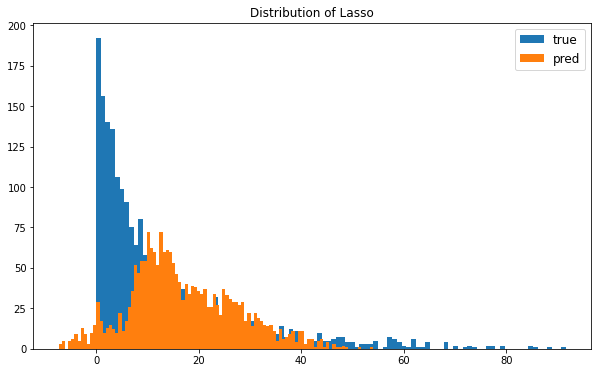

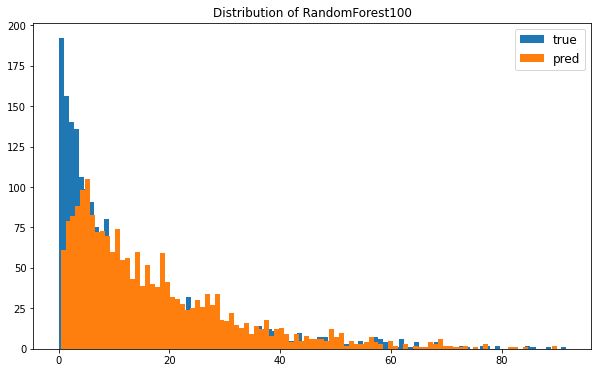

In [83]:
algos = [
         (NormalPredictor(), 'NormalPredictor', True),
         (BaselineOnly(), 'BaseLine', True),
         (KNNWithMeans(k=20), 'KNNWithMeans k=20', True),
         (KNNBaseline(k=10), 'KNNBaseline k=10', True),
         (CoClustering(n_cltr_u=20, n_cltr_i=20), 'CoClustering20x20', True),
         (SVD(n_factors=5), 'SVD5', True),
         (SVD(n_factors=300), 'SVD300', True),
         (Lasso(alpha=0.01), 'Lasso', False),
#          (MLPRegressor(hidden_layer_sizes=(50, 50)), 'MLP50x50', False),
#          (RandomForestRegressor(n_estimators=50, n_jobs=-1), 'RandomForest50', False),
         (RandomForestRegressor(n_estimators=100, n_jobs=-1), 'RandomForest100', False),
#          (RandomForestRegressor(n_estimators=200, n_jobs=-1), 'RandomForest200', False),
#          (RandomForestRegressor(n_estimators=300, n_jobs=-1), 'RandomForest300', False),
#          (AdaBoostRegressor(n_estimators=100), 'AdaBoost', False)
        ]

results = []
for algo, name, is_surprise in algos:
    print(f'Running: {name}')
    if is_surprise:
        data = Dataset.load_from_df(
            train[['cust_id', 'sku', 'rank']], reader
        )
        trainset = data.build_full_trainset()
        algo.fit(trainset)
        preds = predict(algo, test[['cust_id', 'sku', 'rank']])
        result = show_metrics(preds, name, is_surprise)
        results.append(result)
    else:
        X_trains = train.drop(['sku', 'cust_id', 'id', 'rank'], axis=1)
        X_tests = test.drop(['sku', 'cust_id', 'id', 'rank'], axis=1)
        y_trains = train['rank']
        y_tests = test['rank']
        algo.fit(X_trains, y_trains)
        preds = algo.predict(X_tests)
#         preds = np.clip(preds, 0, 100000)
        result = show_metrics([y_tests, preds], name, is_surprise)
        results.append(result)

display(pd.DataFrame(results))

## Running Hybrid Model

In [84]:
def show_metrics_comb(y_true, y_pred, test, title):
#     precisions, recalls = precision_recall_at_k(preds)
#     prec = round(sum(prec for prec in precisions.values()) / len(precisions), 3)
#     recl = round(sum(rec for rec in recalls.values()) / len(recalls), 3)
    res, _, _ = precision_recall(test, y_pred, k=10)
    prec = res['precision']
    recl = res['recall']
    f1 = res['f1_score']
    
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,6))
    ax.set_title(f'Distribution of Hybrid Model')
    ax.hist(y_true, bins=100, label=f'true')
    ax.hist(y_pred, bins=100, label=f'pred')
    ax.legend(prop={'size': 12})
    return {
        'Model': title,
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RSME': mean_squared_error(y_true, y_pred) ** (1/2),
        'Precision@10': round(prec, 3),
        'Recall@10': round(recl, 3),
        'F1@10': round(f1, 3)
    }

In [87]:
from sklearn.linear_model import LinearRegression

def train_hybrid_model():
    algos = [
         (BaselineOnly(), 'BaseLine', True),
         (KNNWithMeans(k=20), 'KNNWithMeans k=20', True),
         (KNNBaseline(k=10), 'KNNBaseline k=10', True),
         (CoClustering(n_cltr_u=20, n_cltr_i=20), 'CoClustering20x20', True),
         (SVD(n_factors=5), 'SVD5', True),
         (SVD(n_factors=300), 'SVD300', True),
         (Lasso(alpha=0.01), 'Lasso', False),
         (MLPRegressor(hidden_layer_sizes=(50, 50)), 'MLP50x50', False),
#          (RandomForestRegressor(n_estimators=50, n_jobs=-1), 'RandomForest50', False),
         (RandomForestRegressor(n_estimators=100, n_jobs=-1), 'RandomForest100', False),
#          (RandomForestRegressor(n_estimators=200, n_jobs=-1), 'RandomForest200', False),
#          (RandomForestRegressor(n_estimators=300, n_jobs=-1), 'RandomForest300', False),
#          (AdaBoostRegressor(n_estimators=100), 'AdaBoost', False)
        ]
    results = []
    combiner = LinearRegression(fit_intercept=True)

    for i in range(3):
        print(f'Dataset: #{i}')
        train, test = load_dataset(i, pipe, df_prod)
        
        combined = []
        for algo, name, is_surprise in algos:
            print(f'Running: {name}')
            if is_surprise:
                data = Dataset.load_from_df(
                    train[['cust_id', 'sku', 'rank']], reader
                )
                trainset = data.build_full_trainset()
                algo.fit(trainset)
                preds = predict(algo, test[['cust_id', 'sku', 'rank']])
                combined.append([p.est for p in preds])
            else:
                X_trains = train.drop(['sku', 'cust_id', 'id', 'rank'], axis=1)
                X_tests = test.drop(['sku', 'cust_id', 'id', 'rank'], axis=1)
                y_trains = train['rank']
                y_tests = test['rank']
                algo.fit(X_trains, y_trains)
                preds = algo.predict(X_tests)
#                 preds = np.clip(preds, 0, 100000)
                combined.append(preds)

        if(i == 0):
            combiner.fit(np.array(combined).T, test['rank'].values)
        y_pred = combiner.predict(np.array(combined).T)
#         y_pred = np.clip(preds, 0, 100000)
        result = show_metrics_comb(test['rank'].values, y_pred, test, i)
        results.append(result)
    return combiner, pd.DataFrame(results)

Dataset: #0
Running: BaseLine
Estimating biases using als...
Running: KNNWithMeans k=20
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: KNNBaseline k=10
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: CoClustering20x20
Running: SVD5
Running: SVD300
Running: Lasso


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Running: MLP50x50


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Running: RandomForest100


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Dataset: #1
Running: BaseLine
Estimating biases using als...
Running: KNNWithMeans k=20
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: KNNBaseline k=10
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: CoClustering20x20
Running: SVD5
Running: SVD300
Running: Lasso


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Running: MLP50x50


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Running: RandomForest100


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Dataset: #2
Running: BaseLine
Estimating biases using als...
Running: KNNWithMeans k=20
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: KNNBaseline k=10
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Running: CoClustering20x20
Running: SVD5
Running: SVD300
Running: Lasso


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Running: MLP50x50


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Running: RandomForest100


c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


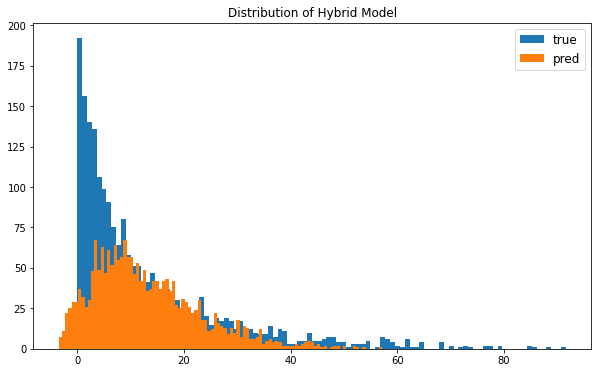

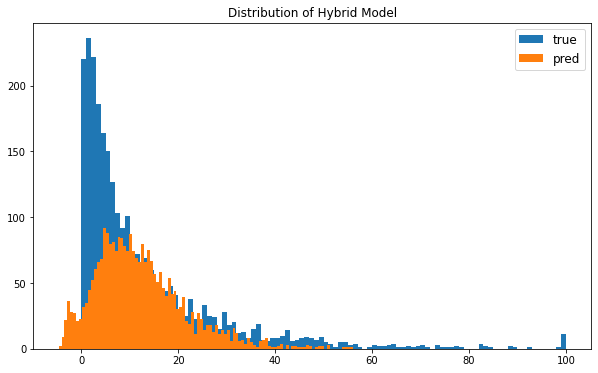

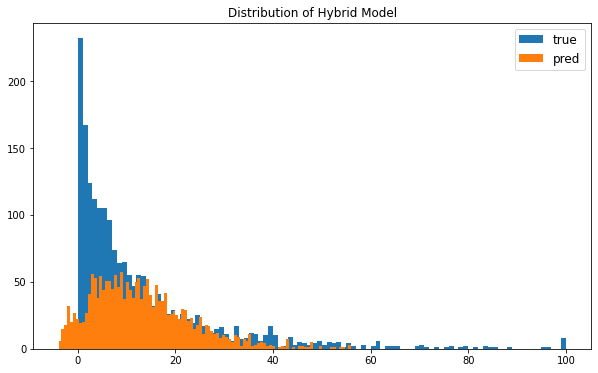

In [88]:
combiner, results = train_hybrid_model()

In [89]:
combiner.coef_

array([ 0.15763402, -0.23332451,  0.26308239,  0.01637258,  0.1523947 ,
        0.01909311,  0.33436155,  0.00566642,  0.20423452])

In [90]:
display(results.mean(axis=0))

Model            1.000000
R2               0.500598
MAE              6.652290
RSME            10.662143
Precision@10     0.818667
Recall@10        0.504000
F1@10            0.605667
dtype: float64

In [91]:
display(results)

,Model,R2,MAE,RSME,Precision@10,Recall@10,F1@10
0,0,0.489220,6.622450,10.455418,0.816,0.522,0.621
1,1,0.461347,6.616335,11.152093,0.822,0.483,0.590
2,2,0.551226,6.718085,10.378917,0.818,0.507,0.606


## Association Rules

## Methodology

### Reason
In addition to personal recommendations the company would like to get sets of products that are commonly bought together. This would be used both to create better promotional campaigns as well as increase cross-selling through integration with their order management system.

Market basked analysis is a type of machine learning methodology to look for correlations and associations between intensities and a transaction. With a large amount of data generated, especially in the retail sector, this type of analysis brings great value in understanding consumer behavior and identifying patterns for business optimization.

As our data is generated by a company in the retail industry, with a large volume of products being negotiated, we thought about using this methodology to implement in the company's interface.

Association rules is a common task in frequent pattern mining. The metrics we are using are provided in the mlxtend package.



### Models
To receive sets of commonly bought products we mine association rules from the database of sales transactions. 

### Metrics
**Support** - This metric is used to understand the abundance or frequency of an item in the database.  $$P(X \cap Y)$$ 

**Confidence** - It is a metric that shows how often the rule occurs that an item is bought together with another one. Generally the results of pairs of items are different. $$\frac{support(X \cap Y)}{support(X)}$$

**Lift** - This is a metric that measures the probability of having item Y in the basket given the knowledge that item X is present versus the probability of having item Y in the basket without knowing about the presence of item X. If item X knows that Y is in the basket, the value of lift is more than 1. In contrast, if the value is less than 1, it shows that having item X in the basket does not increase the chance of having item Y in the basket.. $$ \frac{support(X \cap Y)}{support(X) \times support(Y)}$$

In order to give a proper recommendation, we decided to use the category provided by the company instead of just the SKU, the main reason being that SKU based associations in this type of business (building materials) can be misleading, since for example many similar products with different codes, thus raising the confidence numbers disproportionately.

Thus, we ended up using product category, something not initially saved by the company database. In meetings with the management team, it was provided for us a list of the best selling SKUs with their respective categories. Performing an initial database cleanup to load the market basket analysis (Products available, quantity > 0 and category not null), we reached 72% of the products sold categorized.


In [104]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [105]:
from modules.loader import Loader

In [106]:
loader = Loader()
df_cust = loader.load_customers()
df_inv = loader.load_inventory()
df_sal = loader.load_sales_data()
df_sal = loader.add_channels(df_sal, df_cust)
df_sal = loader.add_nls(df_sal, df_inv)

C:\Users\fpsaw\Desktop\42578-Advanced-Business-Analytics\modules\loader.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  df['username'] = df['username'].str.replace(


In [108]:
# Remove invalid items
df = df_sal.loc[
    (df_sal['NLS'] == False) &
    (~df_sal['price'].between(-1, 1, inclusive=True)) &
    (~df_sal['cost'].between(-1, 1, inclusive=True))
]
df = df.groupby(['sku']).sum().reset_index()
df = df.loc[
    (df['quantity'] > 10) &  # in total at least 10 items sold (minus returns)
    (df['price'] > 100),    # in total at least sold for 100 eur
    ['sku', 'quantity', 'price']
]
print('All unique items sold:', len(df_sal.groupby(['sku']).sum()))
print('Filtered unique items:', len(df))

All unique items sold: 15518
Filtered unique items: 4415


In [110]:
sales_sku = list(df_sal.sku.unique())
active_products = df_inv.sku.isin(sales_sku)
filtered_df = df_inv[active_products]

In [111]:
df_sales = pd.merge(df_sal, df_inv, on='sku')
df_sales = df_sales.drop(columns=['last_cost', 'NLS_y','unit_price','last_cost','descr','quantity_y'])
df_sales = df_sales.rename({'quantity_x': 'quantity','NLS_x':'NLS'}, axis=1) 
df_sales = df_sales[(df_sales.NLS == False)]

In [113]:
df_market = df_sales.loc[
    df_sales['quantity'] > 0 & df_sales.category.notnull(),
    ['sku', 'invoice_no','category', 'quantity']
]

basket = df_market.groupby(['invoice_no', 'category']).sum().unstack().reset_index().fillna(0).set_index('invoice_no')
basket = basket.applymap(lambda x: 0 if x <= 0 else 1)
basket.columns = basket.columns.droplevel()
# Mining part
frequent_itemsets = fpgrowth(basket.astype(bool), min_support=0.005, use_colnames=True)
df_ar = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

In [114]:
# Additional requirement from the company to limit number of antecedents and consequents (max 2)
df_ar = df_ar.sort_values(by=['confidence'], ascending=False).iloc[::2, :]
df_ar = df_ar.loc[df_ar.antecedents.apply(lambda x: len(x) < 3) &
                  df_ar.consequents.apply(lambda x: len(x) < 3) ]

In [115]:
def does_intersect(ant, cats):
    return ((set(cats) & set(ant)) == set(ant))

def does_not_intersect(con, cats):
    return len(set(cats) & set(con)) == 0

In [116]:
def get_recommendations(cats, df_ar, top_k=3):
    # Finds association rules with provided categories
    subset = df_ar.loc[df_ar.antecedents.apply(lambda ant: does_intersect(ant, cats))]
    # Removes association rules which already contain ordered categories
    subset = subset.loc[subset.consequents.apply(lambda con: does_not_intersect(con, cats))]
    print(subset.sort_values(by='confidence', ascending=False).iloc[:3, 0:])

In [117]:
get_recommendations(['Acu Screwdriver', 'Electric Circular Saw', 'Bits Set'], df_ar)

                 antecedents                           consequents  \
329  (Electric Circular Saw)                   (Acu Angle Grinder)   
288  (Electric Circular Saw)                     (Electric Jigsaw)   
334  (Electric Circular Saw)  (Electric Router, Acu Angle Grinder)   

     antecedent support  consequent support   support  confidence      lift  \
329            0.040943            0.109948  0.012945    0.316162  2.875551   
288            0.040943            0.034793  0.008227    0.200944  5.775483   
334            0.040943            0.021365  0.005941    0.145104  6.791686   

     leverage  conviction  
329  0.008443    1.301553  
288  0.006803    1.207934  
334  0.005066    1.144742  


### Conclusion / Results
To assess how well association rules correspond to the expected causal combinations, we've conducted empirical tests with the CEO of the company. 

We have found that the algorithm is sensitive to sorting metrics which results in different although mostly correct results. For example descending lift provides itemsets where both antecedents and consequents are larger in size. Confidence on the other hand outputs minimal size of antecedent itemset. In the end after experimentation period we have settled on current hyperparameters and metrics that will be used to generate category recommendations further in company's internal order management system.